In [1]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


In [2]:
RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

In [3]:

# Load the dataset (replace 'train_dataset.csv' with your dataset path)
df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_train = pd.read_csv(df_train_path)

# Composite feature for history_of_violence
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] + df_train["juv_misd_count"] + df_train["juv_other_count"] + df_train["priors_count"]
)

# Socioeconomic stability proxy
df_train["socioeconomic_stability"] = 1 / (1 + df_train["priors_count"])

# Composite risk score formula: weighted combination of key features
composite_weights = {
    "priors_count": 0.4,
    "history_of_violence": 0.5,
    "c_charge_degree_F": 0.3,
    "c_charge_degree_M": -0.3
}

df_train["composite_risk"] = (
    composite_weights["priors_count"] * df_train["priors_count"] +
    composite_weights["history_of_violence"] * df_train["history_of_violence"] +
    composite_weights["c_charge_degree_F"] * df_train["c_charge_degree_F"] +
    composite_weights["c_charge_degree_M"] * df_train["c_charge_degree_M"]
)


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Select relevant features for the model
X_train = df_train[[
    "age", "priors_count", "history_of_violence", "days_b_screening_arrest", 
    "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"
]]

y_train = df_train["composite_risk"]  # Use composite risk score as the target variable

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_pred = model.predict(X_train_scaled)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error (Composite Risk): {mse}")
print(f"R-squared Score (Composite Risk): {r2}")


Mean Squared Error (Composite Risk): 1.6011324684004356e-29
R-squared Score (Composite Risk): 1.0


In [6]:
# Coefficients (interpretable weights)
print("Intercept (w_0):", model.intercept_)
print("Coefficients (w_1, w_2, ...):", model.coef_)

# Feature importance
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})
print(coefficients)


Intercept (w_0): 3.3306359383122506
Coefficients (w_1, w_2, ...): [ 3.45536071e-16  1.94210791e+00  2.59562395e+00  2.22044605e-16
 -1.11022302e-16  1.43011347e-01 -1.43011347e-01]
                   Feature   Coefficient
0                      age  3.455361e-16
1             priors_count  1.942108e+00
2      history_of_violence  2.595624e+00
3  days_b_screening_arrest  2.220446e-16
4  socioeconomic_stability -1.110223e-16
5        c_charge_degree_F  1.430113e-01
6        c_charge_degree_M -1.430113e-01


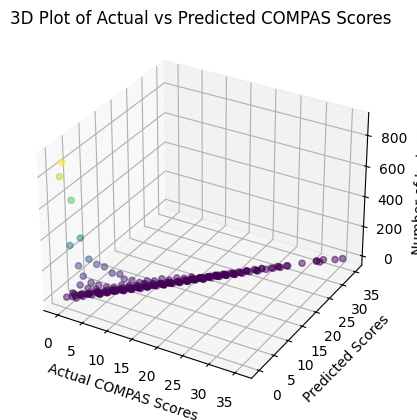

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Visualization: 3D Plot of Actual vs Predicted vs Instance Count
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Count the number of instances for each unique pair of actual and predicted scores
unique_pairs, counts = np.unique(
    np.column_stack((y_train, y_pred.round())), axis=0, return_counts=True
)

# Extract unique actual, predicted, and counts
actual_scores = unique_pairs[:, 0]
predicted_scores = unique_pairs[:, 1]

# Create the 3D scatter plot
ax.scatter(actual_scores, predicted_scores, counts, alpha=0.5, c=counts, cmap='viridis')
ax.set_xlabel("Actual COMPAS Scores")
ax.set_ylabel("Predicted Scores")
ax.set_zlabel("Number of Instances")
ax.set_title("3D Plot of Actual vs Predicted COMPAS Scores")

plt.show()


Correlation with Decile Score: 0.4629353084990606


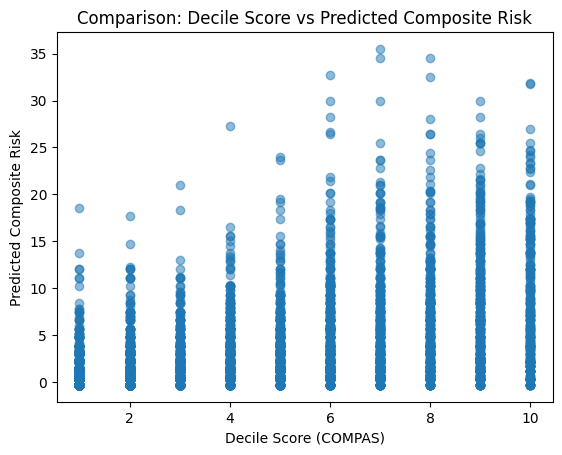

0.4629353084990606


In [9]:
# Compare predictions to decile_score
comparison = pd.DataFrame({
    "Decile Score": df_train["decile_score"],  # Actual COMPAS scores
    "Predicted Composite Risk": y_pred        # Predicted scores from the model
})

# Calculate the correlation between Decile Score and Predicted Scores
correlation = comparison.corr().loc["Decile Score", "Predicted Composite Risk"]
print(f"Correlation with Decile Score: {correlation}")

# Plot Actual Decile Score vs Predicted Composite Risk
plt.scatter(comparison["Decile Score"], comparison["Predicted Composite Risk"], alpha=0.5)
plt.xlabel("Decile Score (COMPAS)")
plt.ylabel("Predicted Composite Risk")
plt.title("Comparison: Decile Score vs Predicted Composite Risk")
plt.show()

print(correlation)

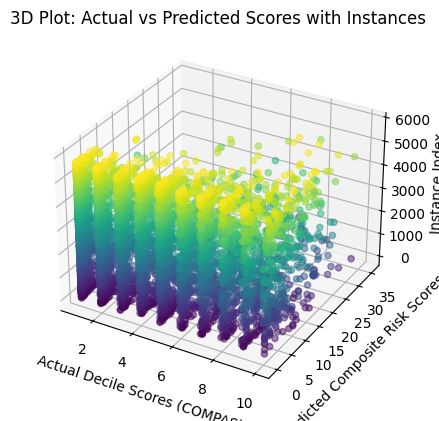

In [10]:
# Visualization: 3D Plot of Actual vs Predicted vs Decile Score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Prepare data for plotting
actual_scores = df_train["decile_score"]
predicted_scores = y_pred
instances = np.arange(len(y_pred))  # Use instance index as the third dimension

# Create the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(actual_scores, predicted_scores, instances, alpha=0.5, c=instances, cmap='viridis')
ax.set_xlabel("Actual Decile Scores (COMPAS)")
ax.set_ylabel("Predicted Composite Risk Scores")
ax.set_zlabel("Instance Index")
ax.set_title("3D Plot: Actual vs Predicted Scores with Instances")

plt.show()


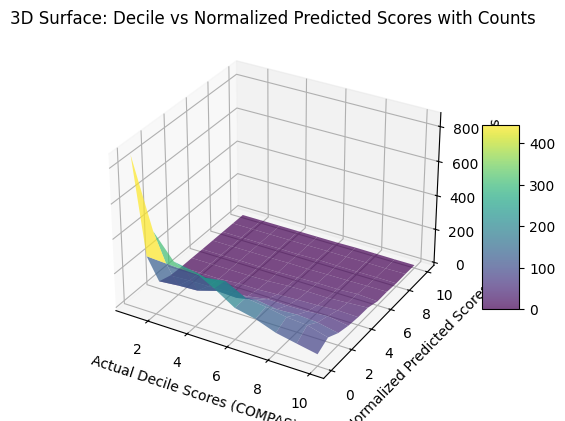

In [14]:
# Normalize the predicted values to lie between 0 and 10
y_pred_normalized = 10 * (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())

# Add normalized predictions to the DataFrame for plotting
df_train['rounded_actual'] = df_train['decile_score'].round()
df_train['rounded_predicted'] = np.round(y_pred_normalized)

# Create a pivot table to count instances for each pair of actual and predicted scores
pivot_table = df_train.pivot_table(
    index='rounded_actual',
    columns='rounded_predicted',
    aggfunc='size',
    fill_value=0
)

# Create meshgrid for plotting
actual_grid, predicted_grid = np.meshgrid(pivot_table.index, pivot_table.columns)
counts = pivot_table.values

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(actual_grid, predicted_grid, counts.T, cmap=cm.viridis, alpha=0.7)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel("Actual Decile Scores (COMPAS)")
ax.set_ylabel("Normalized Predicted Scores")
ax.set_zlabel("Count of Instances")
ax.set_title("3D Surface: Decile vs Normalized Predicted Scores with Counts")

plt.show()
